In [1]:
# `cnn_4_llm_memo`

# Copyright 2025-present Laboratoire d'Informatique de Polytechnique.
# Apache Licence v2.0.

import os

os.chdir(os.path.dirname(os.path.abspath('')))

**WARNING: you must login to the same wandb account as the one used to upload your experiments**

## Setup

In [2]:
import src

In [3]:
from src.utils import paths
from src.detect import DetectConfig
from src.patterns import PatternsConfig, get_titles

In [45]:
from collections import defaultdict
from datetime import datetime

import torch
import wandb
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick

In [5]:
# You can use the following to declare your base output dir if it is not ./output

# import os
# os.environ["_BASE_OUTPUT_DIR"] = "/lustre/fsn1/projects/rech/yfw/upp42qa/output_regu_detect"

## Wandb load

In [6]:
api = wandb.Api()

In [7]:
project_name = "regu_detect"
runs = api.runs(
    project_name,
    filters={
        "group": "SIZE",
    }
)
runs = [
    r
    for r in runs
    if r.summary["_timestamp"] > datetime(2025, 3, 25, 0, 0, 0, 0).timestamp()
]
print(len(runs))

1440


In [8]:
data = []

for r in tqdm(runs):

    detect_config = DetectConfig.autoconfig(r.name[:4], reset_output_dir=True)
    patterns_config = PatternsConfig.autoconfig(detect_config.patterns_config, reset_output_dir=True)
    history_df = r.history()
    num_classes = len([c for c in history_df.columns if "per_class_accuracy." in c])
    to_append = dict(
        run_id=r.id,
        detect_cfg=detect_config.get_id(),
        patterns_cfg=r.config["patterns_config"],
        detection_hash=r.config["detection_hash"],
        tax_name=patterns_config.tax_name,
        n_feat_cnn=r.config["n_feat_cnn"],
        kernel_size=r.config["kernel_size"],
        head_pooling=r.config["head_pooling"],
        num_classes=num_classes,
        patterns_size=r.config["patterns_size"],
        patterns_duplicates_threshold=r.config["patterns_duplicates_threshold"],

    )

    for step in range(1, r.summary["_step"] + 1):
        to_append[f"train_loss_{step}"] = history_df.loc[step, "train_loss"]
        to_append[f"eval_loss_{step}"] = history_df.loc[step, "eval_loss"]
        to_append[f"overall_accuracy_{step}"] = history_df.loc[step, "overall_accuracy"]
    
    data.append(to_append)


100%|██████████| 1440/1440 [10:45<00:00,  2.23it/s]


In [9]:
df = pd.DataFrame(data)
df

,run_id,detect_cfg,patterns_cfg,detection_hash,tax_name,n_feat_cnn,kernel_size,head_pooling,num_classes,patterns_size,patterns_duplicates_threshold,train_loss_1,eval_loss_1,overall_accuracy_1,train_loss_2,eval_loss_2,overall_accuracy_2,train_loss_3,eval_loss_3,overall_accuracy_3
0,9pb4u2c9,RBPIyXb_WnoQqfJPUk2g3w,LHAuNglSzB0DU89x1gK1jQ,_460xJ7Xj-K8fuY2nhYhfw,merge_1_other_recite_code_recollect,10,6,mean,3,12b,5,0.046749,0.042260,0.782500,0.034863,0.036832,0.768000,0.032955,0.035409,0.787500
1,y5js4lx1,uNpT74v6FUhPlJC07Uu7WA,RPR_HV0pbU_xj96mVDgxmw,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_code_recollect_recite,10,6,mean,3,12b,5,0.043645,0.037280,0.794000,0.030037,0.029459,0.839667,0.027851,0.029430,0.841333
2,537supwn,cGC6PbcqqAmRyME_r2sv6g,LHAuNglSzB0DU89x1gK1jQ,GoY1ApGWnKbHCaNUqawmsw,merge_1_other_recite_code_recollect,10,6,max,3,12b,5,0.044747,0.039327,0.792667,0.034354,0.036383,0.784500,0.032144,0.033313,0.810667
3,s6nsauqe,2-nUe3ZvRtQskLppJh2sOg,2G944b53Aife71_OTKuyuQ,_460xJ7Xj-K8fuY2nhYhfw,other_recollect_code_recite,10,6,mean,4,12b,5,0.053042,0.045532,0.765125,0.040605,0.041093,0.797875,0.038912,0.041917,0.803875
4,xdmv5gqm,VjcWwY2PUUUHqD50oo9lWA,o6EWeQiWVjx7iNKtoKDyRg,_460xJ7Xj-K8fuY2nhYhfw,other_code_recite_recollect,10,6,mean,4,12b,5,0.060352,0.057909,0.638500,0.046411,0.048454,0.743375,0.043790,0.047274,0.756000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,hch0vexr,MH0k7VyZyDhty0XgfGvtgg,rCszFZxPwkhecfgBtewv5g,dJ2YeckSA-Oj3SPTDY_dMw,other_code_recite_recollect,16,8,mean,4,2.8b,1000,0.059851,0.051417,0.696875,0.048302,0.049813,0.681625,0.045959,0.049258,0.706000
1436,9xixxf4e,3UFCBcmoXZ5irfZvu3Zn6A,eZRNtWqaHJXnklCiBDd-Zg,dJ2YeckSA-Oj3SPTDY_dMw,other_recite_code_recollect,16,8,mean,4,2.8b,1000,0.058897,0.053059,0.673875,0.047444,0.048015,0.710625,0.044679,0.049394,0.718125
1437,qkehxhv4,DlotzN7aF_MwIUG4_tQ9Ag,ncTWMJS-LQKuXNbpRf3YIw,FarDo9MIDjoNWFe_WKPV9Q,other_recollect_code_recite,16,8,max,4,2.8b,1000,0.055606,0.049227,0.733250,0.043260,0.050566,0.708500,0.041396,0.042818,0.761500
1438,y60r7ocv,m7jdGr8L0ynaA7q2vaqztg,rCszFZxPwkhecfgBtewv5g,FarDo9MIDjoNWFe_WKPV9Q,other_code_recite_recollect,16,8,max,4,2.8b,1000,0.060415,0.050880,0.688250,0.048369,0.050443,0.679750,0.046640,0.051703,0.674000


In [10]:
SIZE = None
df = df[df["patterns_size"] == SIZE] if SIZE is not None else df

In [11]:
detection_hash, counts = np.unique(df["detection_hash"], return_counts=True)
print(detection_hash, counts)

['FarDo9MIDjoNWFe_WKPV9Q' 'GoY1ApGWnKbHCaNUqawmsw'
 'UCJp0Sru6JlJZsQuDEiGXA' '_460xJ7Xj-K8fuY2nhYhfw'
 'dJ2YeckSA-Oj3SPTDY_dMw' 'gpYtldPwRR9ZBaneI-23_A'
 'iGG8nj8wH6mcvuhwCjb3ow' 'yLjB2-fGaSi7roZyojygbQ'] [180 180 180 180 180 180 180 180]


In [12]:
df

,run_id,detect_cfg,patterns_cfg,detection_hash,tax_name,n_feat_cnn,kernel_size,head_pooling,num_classes,patterns_size,patterns_duplicates_threshold,train_loss_1,eval_loss_1,overall_accuracy_1,train_loss_2,eval_loss_2,overall_accuracy_2,train_loss_3,eval_loss_3,overall_accuracy_3
0,9pb4u2c9,RBPIyXb_WnoQqfJPUk2g3w,LHAuNglSzB0DU89x1gK1jQ,_460xJ7Xj-K8fuY2nhYhfw,merge_1_other_recite_code_recollect,10,6,mean,3,12b,5,0.046749,0.042260,0.782500,0.034863,0.036832,0.768000,0.032955,0.035409,0.787500
1,y5js4lx1,uNpT74v6FUhPlJC07Uu7WA,RPR_HV0pbU_xj96mVDgxmw,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_code_recollect_recite,10,6,mean,3,12b,5,0.043645,0.037280,0.794000,0.030037,0.029459,0.839667,0.027851,0.029430,0.841333
2,537supwn,cGC6PbcqqAmRyME_r2sv6g,LHAuNglSzB0DU89x1gK1jQ,GoY1ApGWnKbHCaNUqawmsw,merge_1_other_recite_code_recollect,10,6,max,3,12b,5,0.044747,0.039327,0.792667,0.034354,0.036383,0.784500,0.032144,0.033313,0.810667
3,s6nsauqe,2-nUe3ZvRtQskLppJh2sOg,2G944b53Aife71_OTKuyuQ,_460xJ7Xj-K8fuY2nhYhfw,other_recollect_code_recite,10,6,mean,4,12b,5,0.053042,0.045532,0.765125,0.040605,0.041093,0.797875,0.038912,0.041917,0.803875
4,xdmv5gqm,VjcWwY2PUUUHqD50oo9lWA,o6EWeQiWVjx7iNKtoKDyRg,_460xJ7Xj-K8fuY2nhYhfw,other_code_recite_recollect,10,6,mean,4,12b,5,0.060352,0.057909,0.638500,0.046411,0.048454,0.743375,0.043790,0.047274,0.756000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,hch0vexr,MH0k7VyZyDhty0XgfGvtgg,rCszFZxPwkhecfgBtewv5g,dJ2YeckSA-Oj3SPTDY_dMw,other_code_recite_recollect,16,8,mean,4,2.8b,1000,0.059851,0.051417,0.696875,0.048302,0.049813,0.681625,0.045959,0.049258,0.706000
1436,9xixxf4e,3UFCBcmoXZ5irfZvu3Zn6A,eZRNtWqaHJXnklCiBDd-Zg,dJ2YeckSA-Oj3SPTDY_dMw,other_recite_code_recollect,16,8,mean,4,2.8b,1000,0.058897,0.053059,0.673875,0.047444,0.048015,0.710625,0.044679,0.049394,0.718125
1437,qkehxhv4,DlotzN7aF_MwIUG4_tQ9Ag,ncTWMJS-LQKuXNbpRf3YIw,FarDo9MIDjoNWFe_WKPV9Q,other_recollect_code_recite,16,8,max,4,2.8b,1000,0.055606,0.049227,0.733250,0.043260,0.050566,0.708500,0.041396,0.042818,0.761500
1438,y60r7ocv,m7jdGr8L0ynaA7q2vaqztg,rCszFZxPwkhecfgBtewv5g,FarDo9MIDjoNWFe_WKPV9Q,other_code_recite_recollect,16,8,max,4,2.8b,1000,0.060415,0.050880,0.688250,0.048369,0.050443,0.679750,0.046640,0.051703,0.674000


In [13]:
len(np.unique(df["patterns_cfg"]))

180

In [14]:
DELTA_INVARIANT_TO_KEEP = 50

## Confusion matrix

In [61]:
conf_matrix_per_tax_name_and_thd = {}

for tax_name in np.unique(df["tax_name"]):

    for patterns_duplicates_threshold in np.unique(df["patterns_duplicates_threshold"]):

        # Skipping 50- when \delta is not used
        if (
            (
                f"merge_2_other_reconstruct" in tax_name
                or f"merge_2_other_guess" in tax_name
                or f"merge_2_other_code" in tax_name
            ) and patterns_duplicates_threshold != DELTA_INVARIANT_TO_KEEP
        ):
            continue

        # Init
        filter = ((df["tax_name"] == tax_name) & (df["patterns_duplicates_threshold"] == patterns_duplicates_threshold))
        filtered_df = df[filter]
        num_classes = filtered_df["num_classes"].iloc[0]
        result = np.zeros((num_classes, num_classes))

        # Iterating detect config
        counter = 0
        for detect_id in filtered_df["detect_cfg"]:
            detect_cfg = DetectConfig.autoconfig(detect_id)        
            
            for step in range(3):
                savable = torch.load(   
                    detect_cfg.get_output_dir() / "cnn_2d" / f"forward_values_{step}.pt", map_location=torch.device('cpu'), weights_only=True
                    )

                predicted_labels = torch.argmax(savable[1], dim=1)
                conf_matrix = confusion_matrix(savable[2].numpy(), predicted_labels.numpy())
                
                result += conf_matrix
                counter += 1

        conf_matrix_per_tax_name_and_thd[tax_name, patterns_duplicates_threshold] = result.astype(int)

In [84]:
# Checking that each taxonomy is plotted exactly once
tax_plotted_count = defaultdict(int)

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/3390878119.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


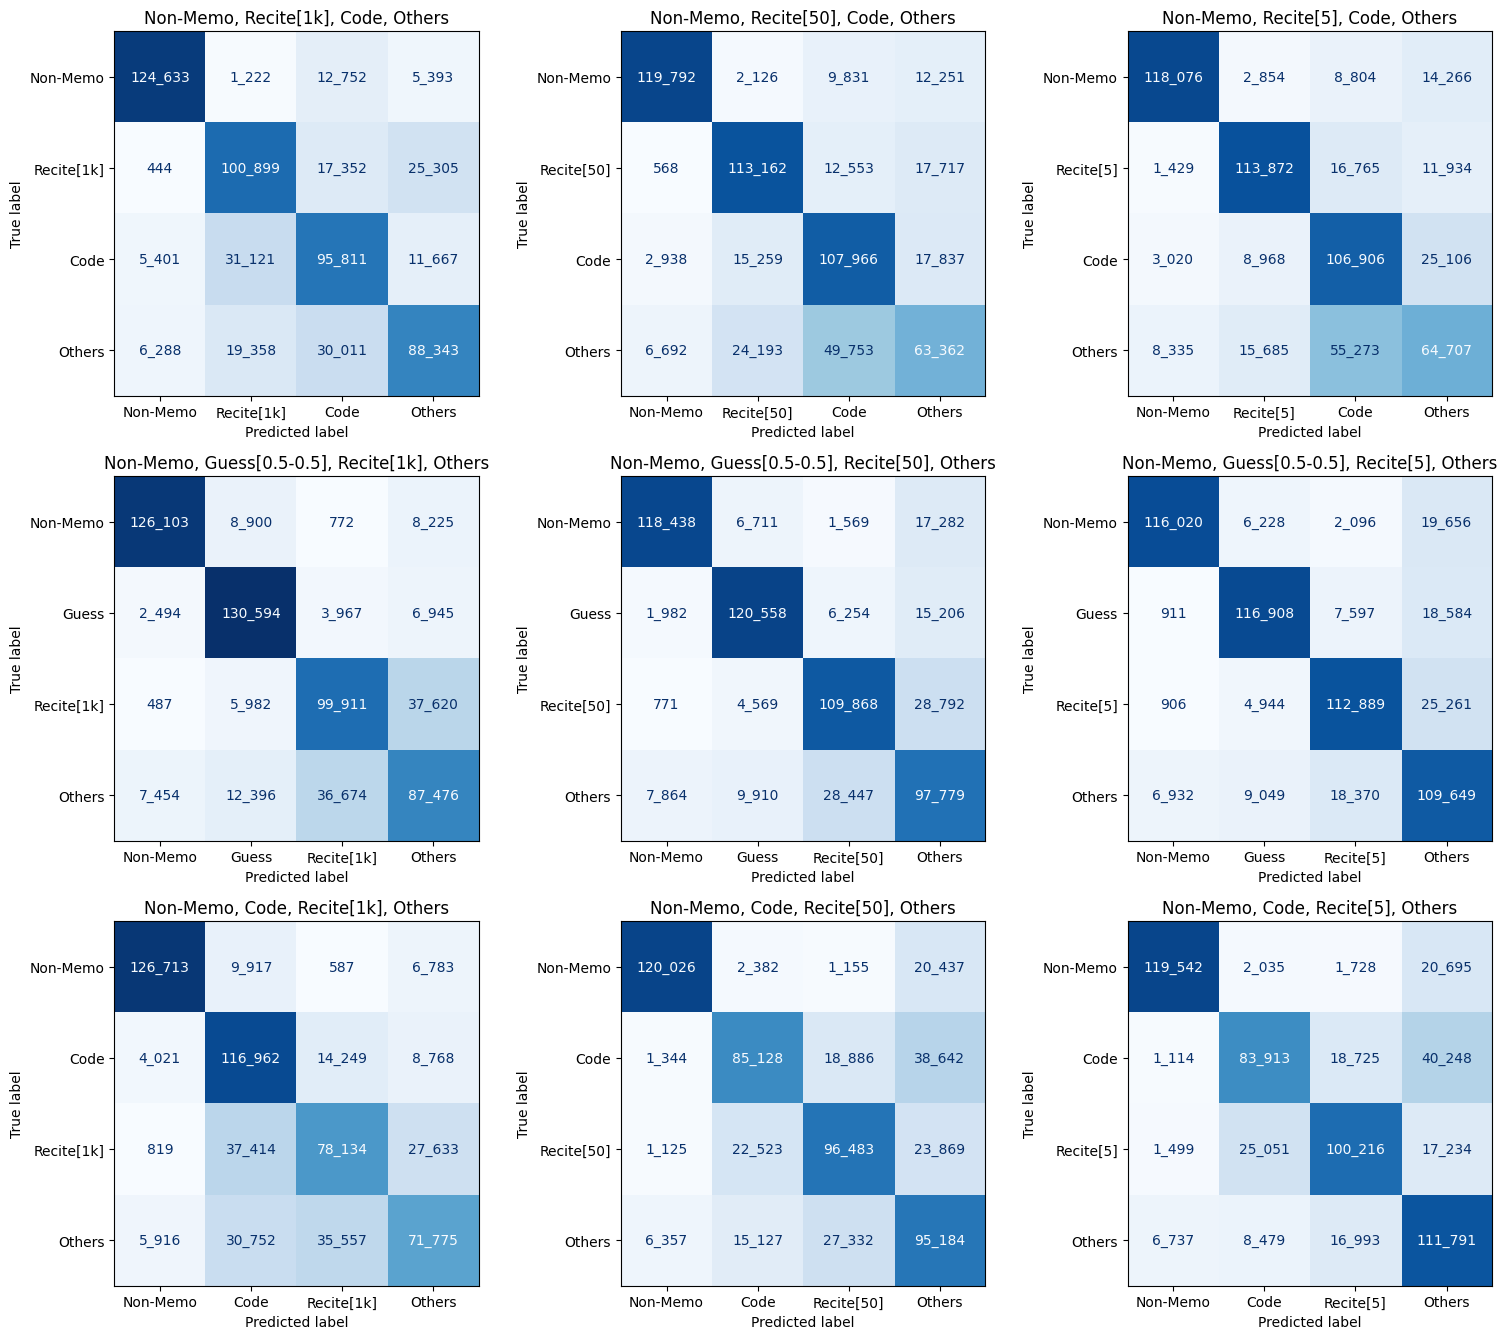

In [85]:
conf_matrix_to_plot = {
    (tax_name, dupl_thd) :v
    for (tax_name, dupl_thd), v in conf_matrix_per_tax_name_and_thd.items()
    if "merge" not in tax_name
}

conf_matrix_to_plot = {
    k:v
    for (idx, (k,v)) in enumerate(conf_matrix_to_plot.items())
    if idx < 9
}

num_tax_names = len(conf_matrix_to_plot)

n_cols = 3
n_rows = (num_tax_names - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4.5*n_rows))

global_min = min(np.min(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())
global_max = max(np.max(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())

used_ax_idx = []

for idx_tax_name, (tax_name, dupl_thd) in enumerate(sorted(conf_matrix_to_plot, reverse=True)):

    used_ax_idx.append(idx_tax_name)

    conf_matrix = conf_matrix_to_plot[tax_name, dupl_thd]
    idx_col = idx_tax_name % n_cols
    idx_row = idx_tax_name // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    display = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix,
        display_labels=get_titles(tax_name, dupl_thd),
    )
    display.plot(
        cmap=plt.cm.Blues,
        values_format="_d",
        ax=ax,
        colorbar=False,
    )
    display.im_.set_clim(global_min, global_max)
    titles = get_titles(tax_name, dupl_thd)
    titles_processed = [elt.replace("Guess", "Guess[0.5-0.5]") for elt in titles]
    display.ax_.set_title(", ".join(titles_processed))

    # Update tax checking
    tax_plotted_count[tax_name, dupl_thd] += 1
    
for idx_to_off in range(n_cols * n_rows):
    if idx_to_off in used_ax_idx:
        continue
    
    idx_col = idx_to_off % n_cols
    idx_row = idx_to_off // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    ax.set_axis_off()


fig.tight_layout()
fig.show()
if SIZE is None:
    fig.savefig(paths.figures / f"03_full_confusion_matrix_4_classes_part_1.pdf")

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/3164584466.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


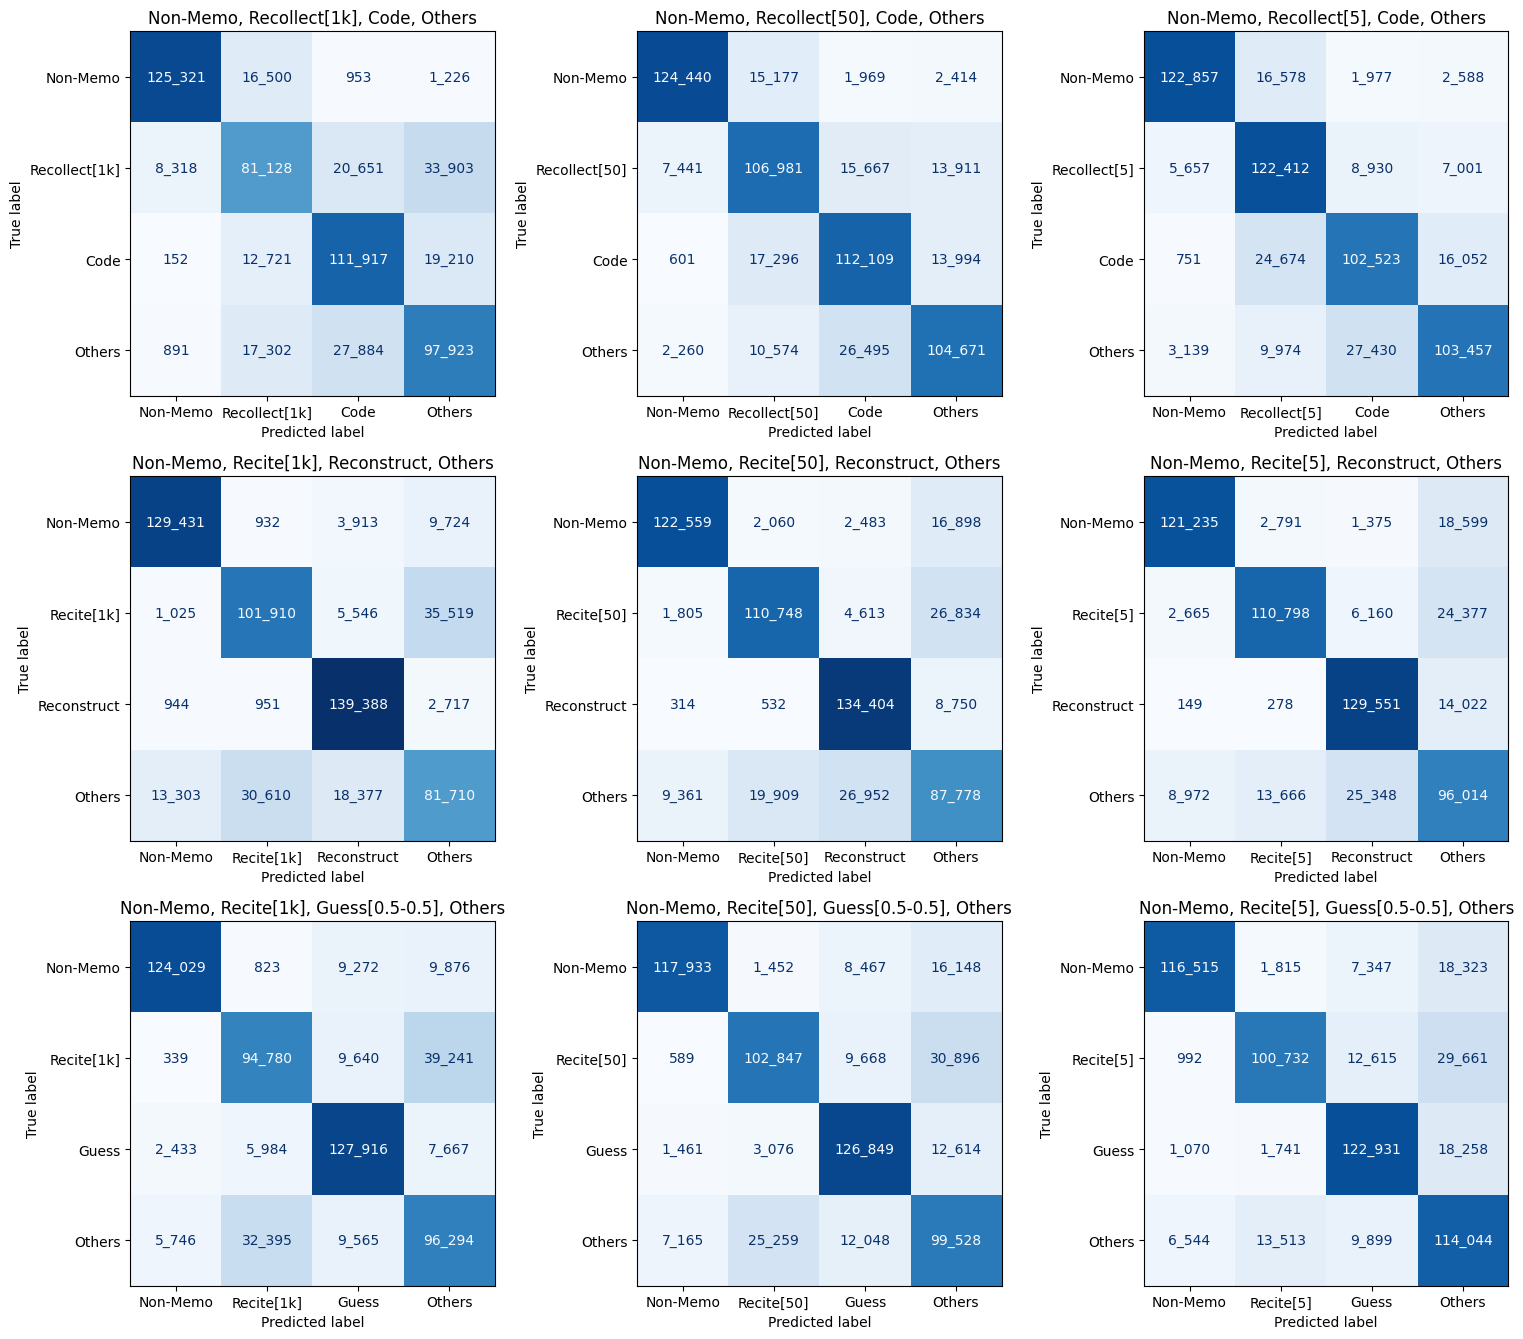

In [86]:
conf_matrix_to_plot = {
    (tax_name, dupl_thd) :v
    for (tax_name, dupl_thd), v in conf_matrix_per_tax_name_and_thd.items()
    if "merge" not in tax_name
}

conf_matrix_to_plot = {
    k:v
    for (idx, (k,v)) in enumerate(conf_matrix_to_plot.items())
    if idx >= 9 and idx < 18
}

num_tax_names = len(conf_matrix_to_plot)

n_cols = 3
n_rows = (num_tax_names - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4.5*n_rows))

global_min = min(np.min(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())
global_max = max(np.max(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())

used_ax_idx = []

for idx_tax_name, (tax_name, dupl_thd) in enumerate(sorted(conf_matrix_to_plot, reverse=True)):

    used_ax_idx.append(idx_tax_name)

    conf_matrix = conf_matrix_to_plot[tax_name, dupl_thd]
    idx_col = idx_tax_name % n_cols
    idx_row = idx_tax_name // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    display = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix,
        display_labels=get_titles(tax_name, dupl_thd),
    )
    display.plot(
        cmap=plt.cm.Blues,
        values_format="_d",
        ax=ax,
        colorbar=False,
    )
    display.im_.set_clim(global_min, global_max)
    titles = get_titles(tax_name, dupl_thd)
    titles_processed = [elt.replace("Guess", "Guess[0.5-0.5]") for elt in titles]
    display.ax_.set_title(", ".join(titles_processed))

    # Update tax checking
    tax_plotted_count[tax_name, dupl_thd] += 1
    
for idx_to_off in range(n_cols * n_rows):
    if idx_to_off in used_ax_idx:
        continue
    
    idx_col = idx_to_off % n_cols
    idx_row = idx_to_off // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    ax.set_axis_off()


fig.tight_layout()
fig.show()
if SIZE is None:
    fig.savefig(paths.figures / f"03_full_confusion_matrix_4_classes_part_2.pdf")

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/2853633987.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


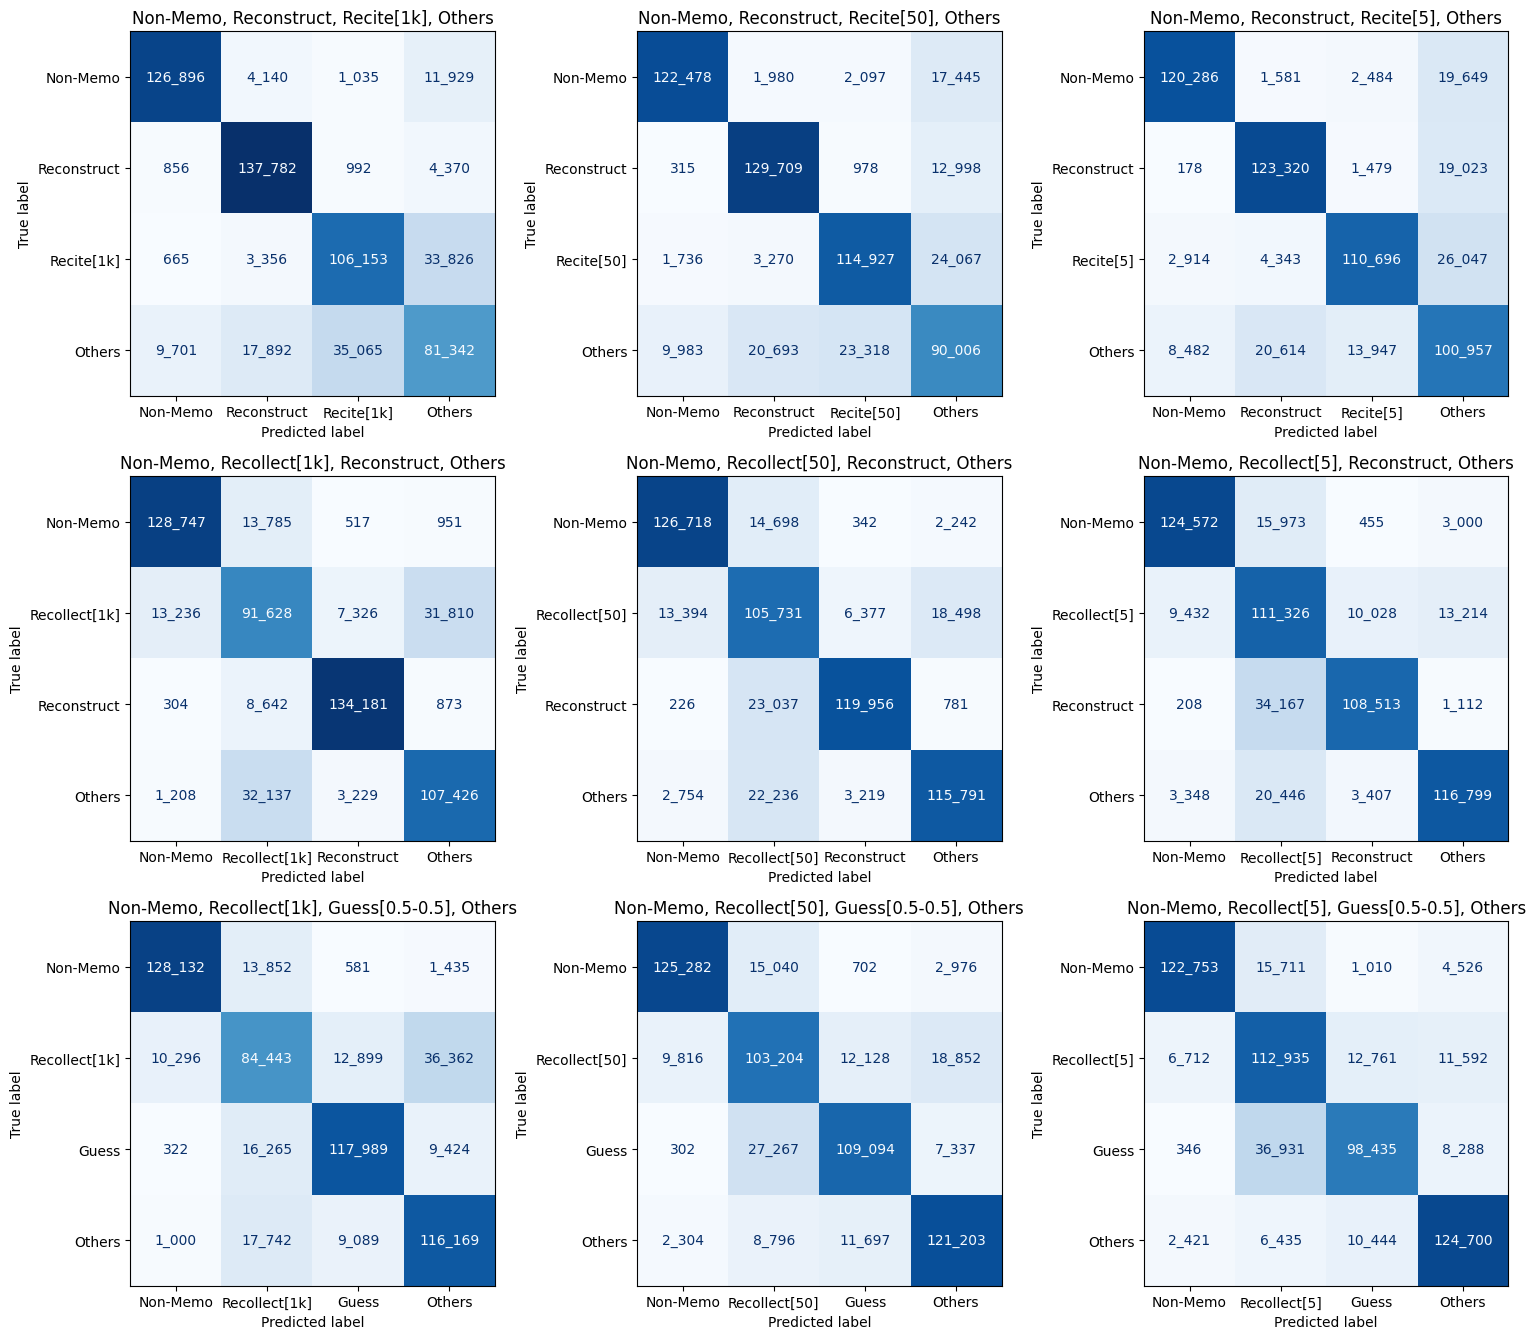

In [87]:
conf_matrix_to_plot = {
    (tax_name, dupl_thd) :v
    for (tax_name, dupl_thd), v in conf_matrix_per_tax_name_and_thd.items()
    if "merge" not in tax_name
}

conf_matrix_to_plot = {
    k:v
    for (idx, (k,v)) in enumerate(conf_matrix_to_plot.items())
    if idx >= 18
}

num_tax_names = len(conf_matrix_to_plot)

n_cols = 3
n_rows = (num_tax_names - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4.5*n_rows))

global_min = min(np.min(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())
global_max = max(np.max(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())

used_ax_idx = []

for idx_tax_name, (tax_name, dupl_thd) in enumerate(sorted(conf_matrix_to_plot, reverse=True)):

    used_ax_idx.append(idx_tax_name)

    conf_matrix = conf_matrix_to_plot[tax_name, dupl_thd]
    idx_col = idx_tax_name % n_cols
    idx_row = idx_tax_name // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    display = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix,
        display_labels=get_titles(tax_name, dupl_thd),
    )
    display.plot(
        cmap=plt.cm.Blues,
        values_format="_d",
        ax=ax,
        colorbar=False,
    )
    display.im_.set_clim(global_min, global_max)
    titles = get_titles(tax_name, dupl_thd)
    titles_processed = [elt.replace("Guess", "Guess[0.5-0.5]") for elt in titles]
    display.ax_.set_title(", ".join(titles_processed))

    # Update tax checking
    tax_plotted_count[tax_name, dupl_thd] += 1
    
for idx_to_off in range(n_cols * n_rows):
    if idx_to_off in used_ax_idx:
        continue
    
    idx_col = idx_to_off % n_cols
    idx_row = idx_to_off // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    ax.set_axis_off()


fig.tight_layout()
fig.show()
if SIZE is None:
    fig.savefig(paths.figures / f"03_full_confusion_matrix_4_classes_part_3.pdf")

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/3364688526.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


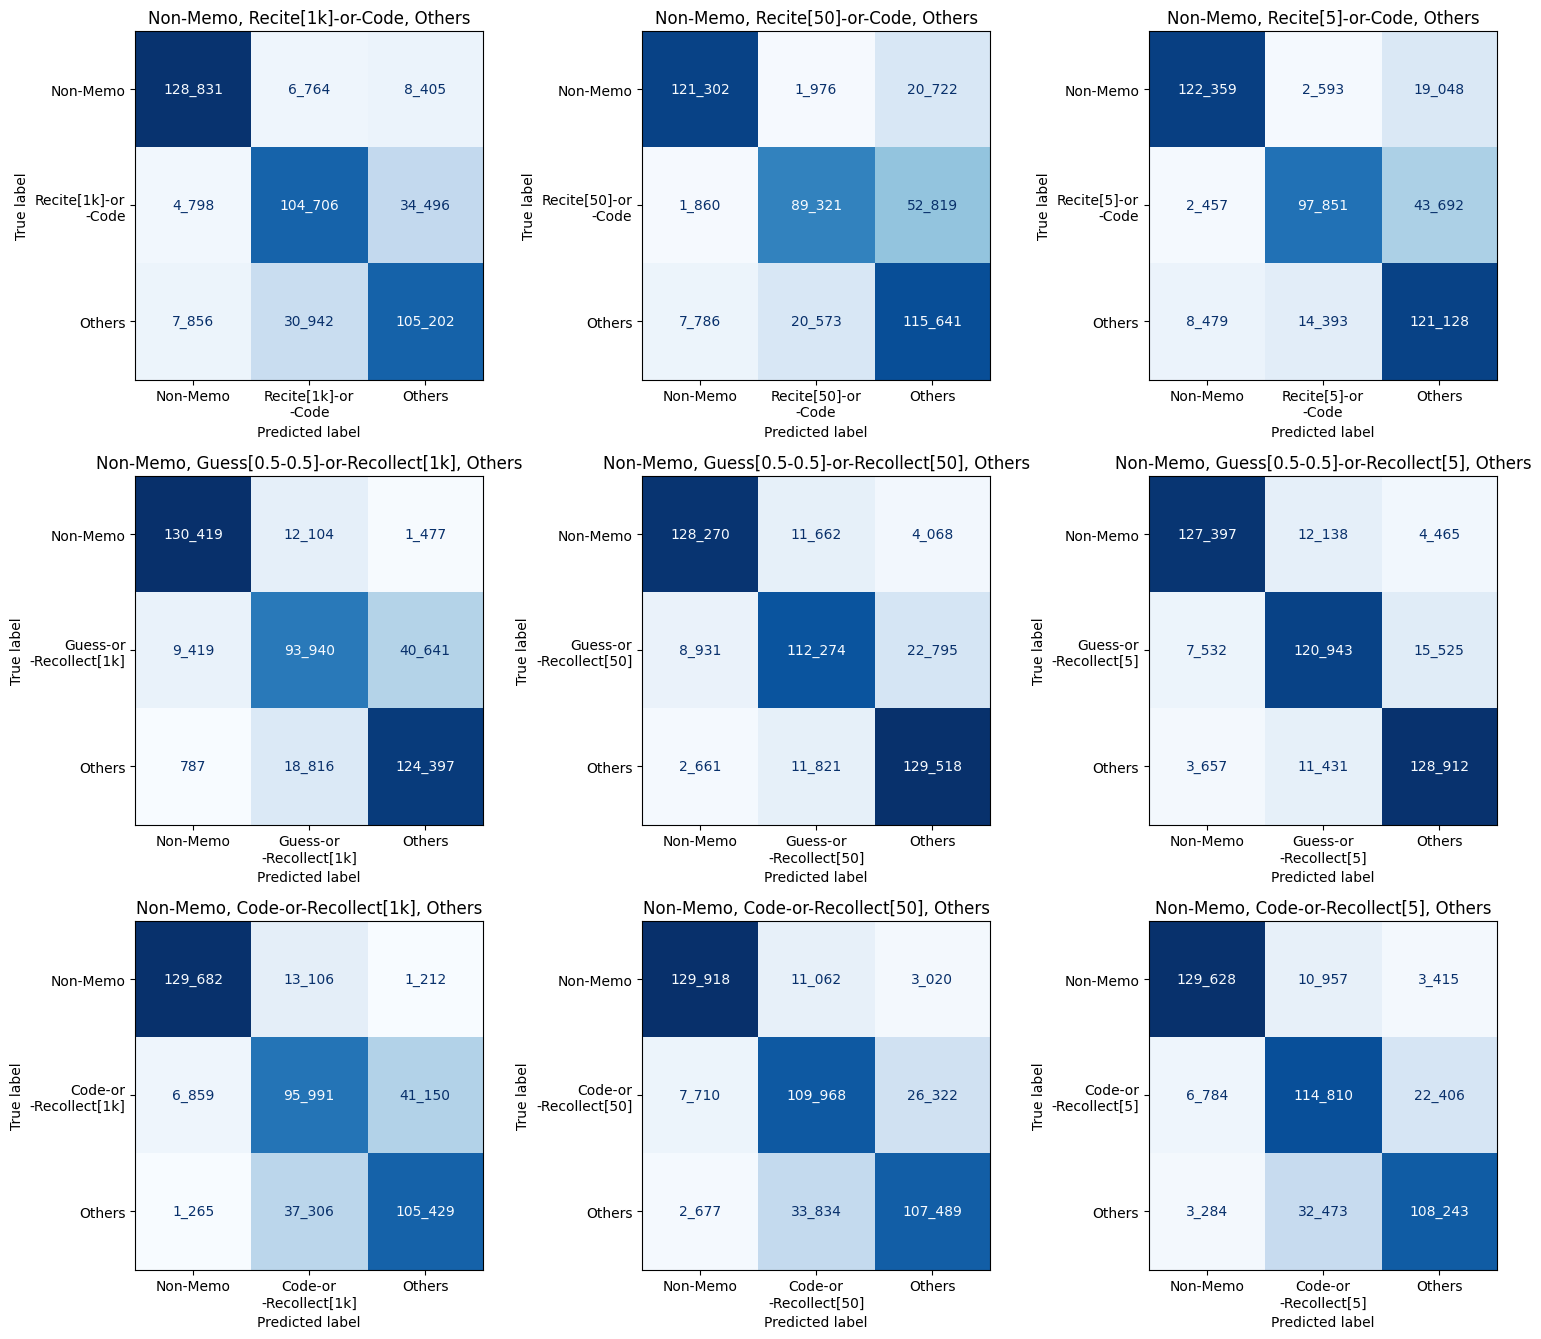

In [88]:
conf_matrix_to_plot = {
    (tax_name, dupl_thd) :v
    for (tax_name, dupl_thd), v in conf_matrix_per_tax_name_and_thd.items()
    if "merge" in tax_name
}

conf_matrix_to_plot = {
    k:v
    for (idx, (k,v)) in enumerate(conf_matrix_to_plot.items())
    if idx < 9
}

num_tax_names = len(conf_matrix_to_plot)

n_cols = 3
n_rows = (num_tax_names - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4.5*n_rows))

global_min = min(np.min(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())
global_max = max(np.max(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())

used_ax_idx = []

for idx_tax_name, (tax_name, dupl_thd) in enumerate(sorted(conf_matrix_to_plot, reverse=True)):

    if idx_tax_name > 27:
        idx_tax_name += 1

    used_ax_idx.append(idx_tax_name)

    conf_matrix = conf_matrix_to_plot[tax_name, dupl_thd]
    idx_col = idx_tax_name % n_cols
    idx_row = idx_tax_name // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    display = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix,
        display_labels=get_titles(tax_name, dupl_thd),
    )
    display.plot(
        cmap=plt.cm.Blues,
        values_format="_d",
        ax=ax,
        colorbar=False,
    )
    display.im_.set_clim(global_min, global_max)
    titles = get_titles(tax_name, dupl_thd, remove_linebreak=True)
    titles_processed = [elt.replace("Guess", "Guess[0.5-0.5]") for elt in titles]
    display.ax_.set_title(", ".join(titles_processed))

    # Update tax checking
    tax_plotted_count[tax_name, dupl_thd] += 1

for idx_to_off in range(n_cols * n_rows):
    if idx_to_off in used_ax_idx:
        continue
    
    idx_col = idx_to_off % n_cols
    idx_row = idx_to_off // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    ax.set_axis_off()


fig.tight_layout()
fig.show()
if SIZE is None:
    fig.savefig(paths.figures / f"03_full_confusion_matrix_3_classes_part_1.pdf")

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/858066549.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


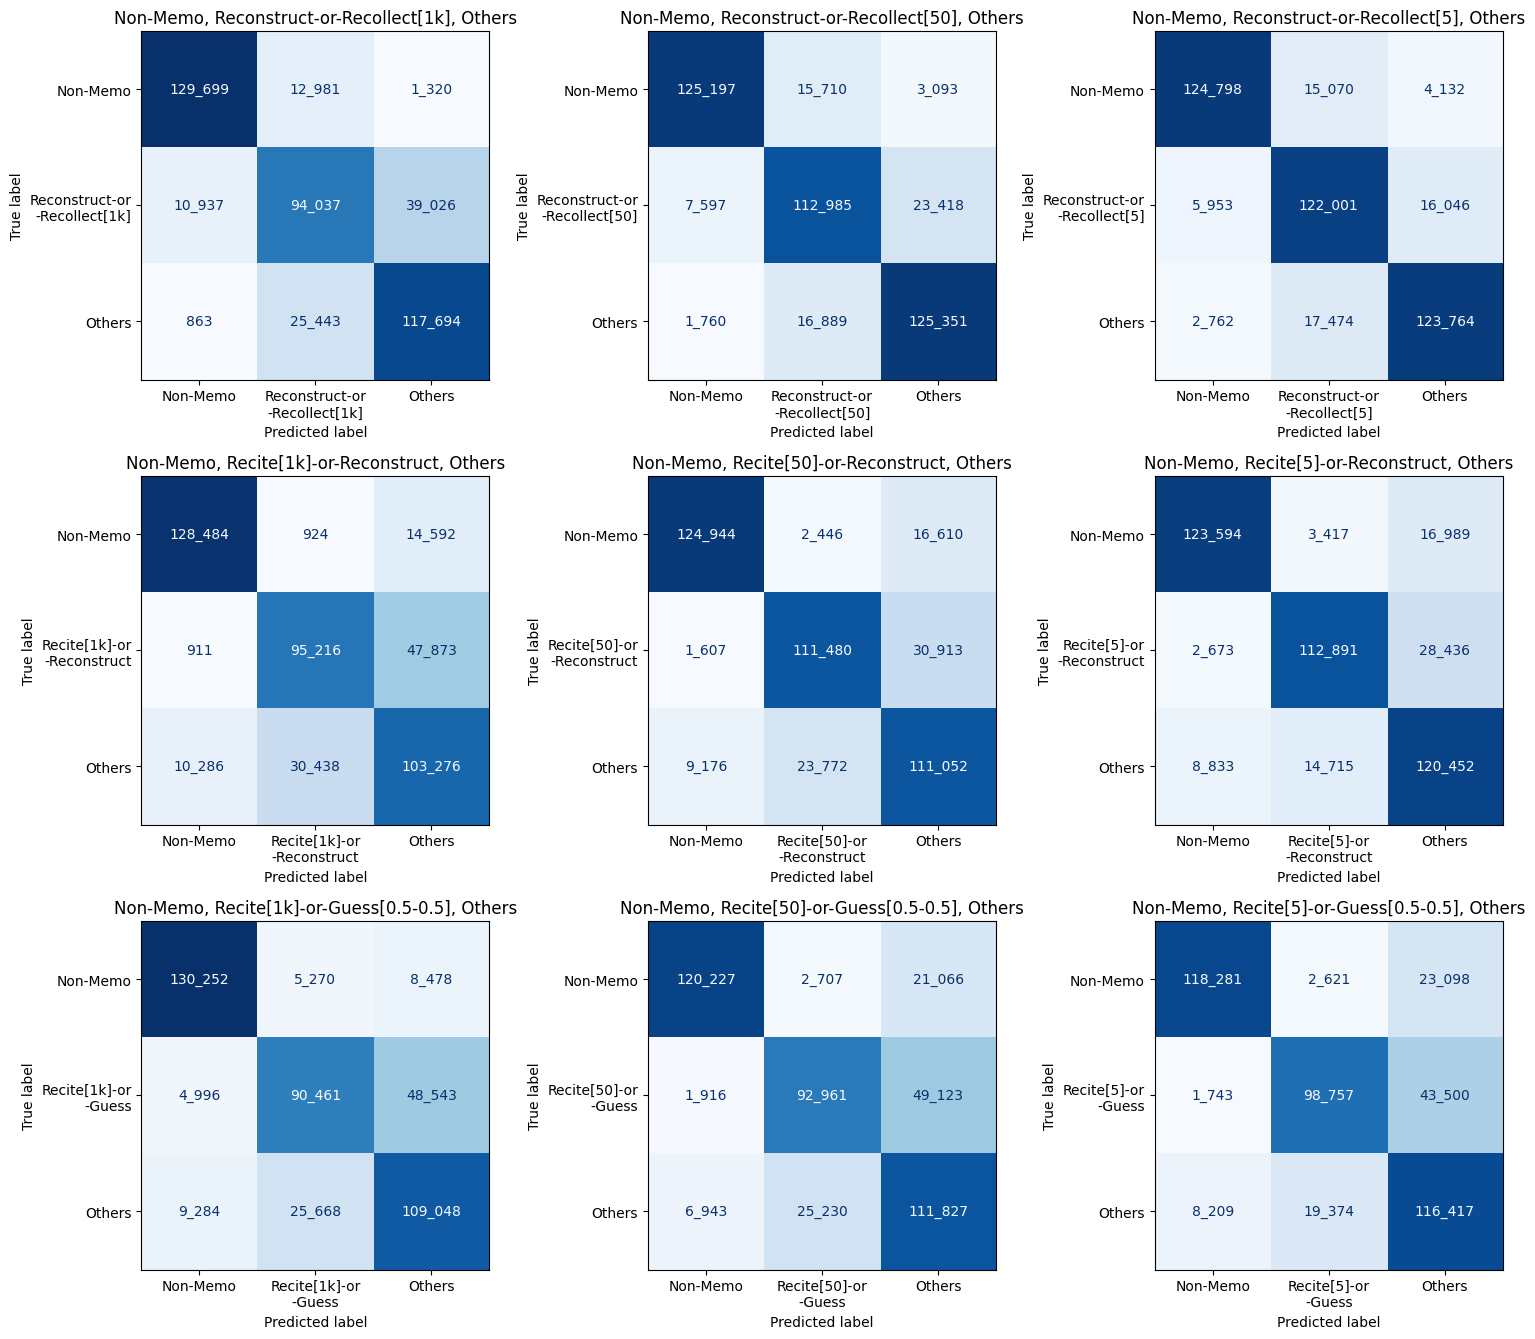

In [89]:
conf_matrix_to_plot = {
    (tax_name, dupl_thd) :v
    for (tax_name, dupl_thd), v in conf_matrix_per_tax_name_and_thd.items()
    if "merge" in tax_name
}

conf_matrix_to_plot = {
    k:v
    for (idx, (k,v)) in enumerate(conf_matrix_to_plot.items())
    if idx >= 9 and idx < 18
}

num_tax_names = len(conf_matrix_to_plot)

n_cols = 3
n_rows = (num_tax_names - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4.5*n_rows))

global_min = min(np.min(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())
global_max = max(np.max(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())

used_ax_idx = []

for idx_tax_name, (tax_name, dupl_thd) in enumerate(sorted(conf_matrix_to_plot, reverse=True)):

    if idx_tax_name > 27:
        idx_tax_name += 1

    used_ax_idx.append(idx_tax_name)

    conf_matrix = conf_matrix_to_plot[tax_name, dupl_thd]
    idx_col = idx_tax_name % n_cols
    idx_row = idx_tax_name // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    display = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix,
        display_labels=get_titles(tax_name, dupl_thd),
    )
    display.plot(
        cmap=plt.cm.Blues,
        values_format="_d",
        ax=ax,
        colorbar=False,
    )
    display.im_.set_clim(global_min, global_max)
    titles = get_titles(tax_name, dupl_thd, remove_linebreak=True)
    titles_processed = [elt.replace("Guess", "Guess[0.5-0.5]") for elt in titles]
    display.ax_.set_title(", ".join(titles_processed))

    # Update tax checking
    tax_plotted_count[tax_name, dupl_thd] += 1

for idx_to_off in range(n_cols * n_rows):
    if idx_to_off in used_ax_idx:
        continue
    
    idx_col = idx_to_off % n_cols
    idx_row = idx_to_off // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    ax.set_axis_off()


fig.tight_layout()
fig.show()
if SIZE is None:
    fig.savefig(paths.figures / f"03_full_confusion_matrix_3_classes_part_2.pdf")

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/846594828.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


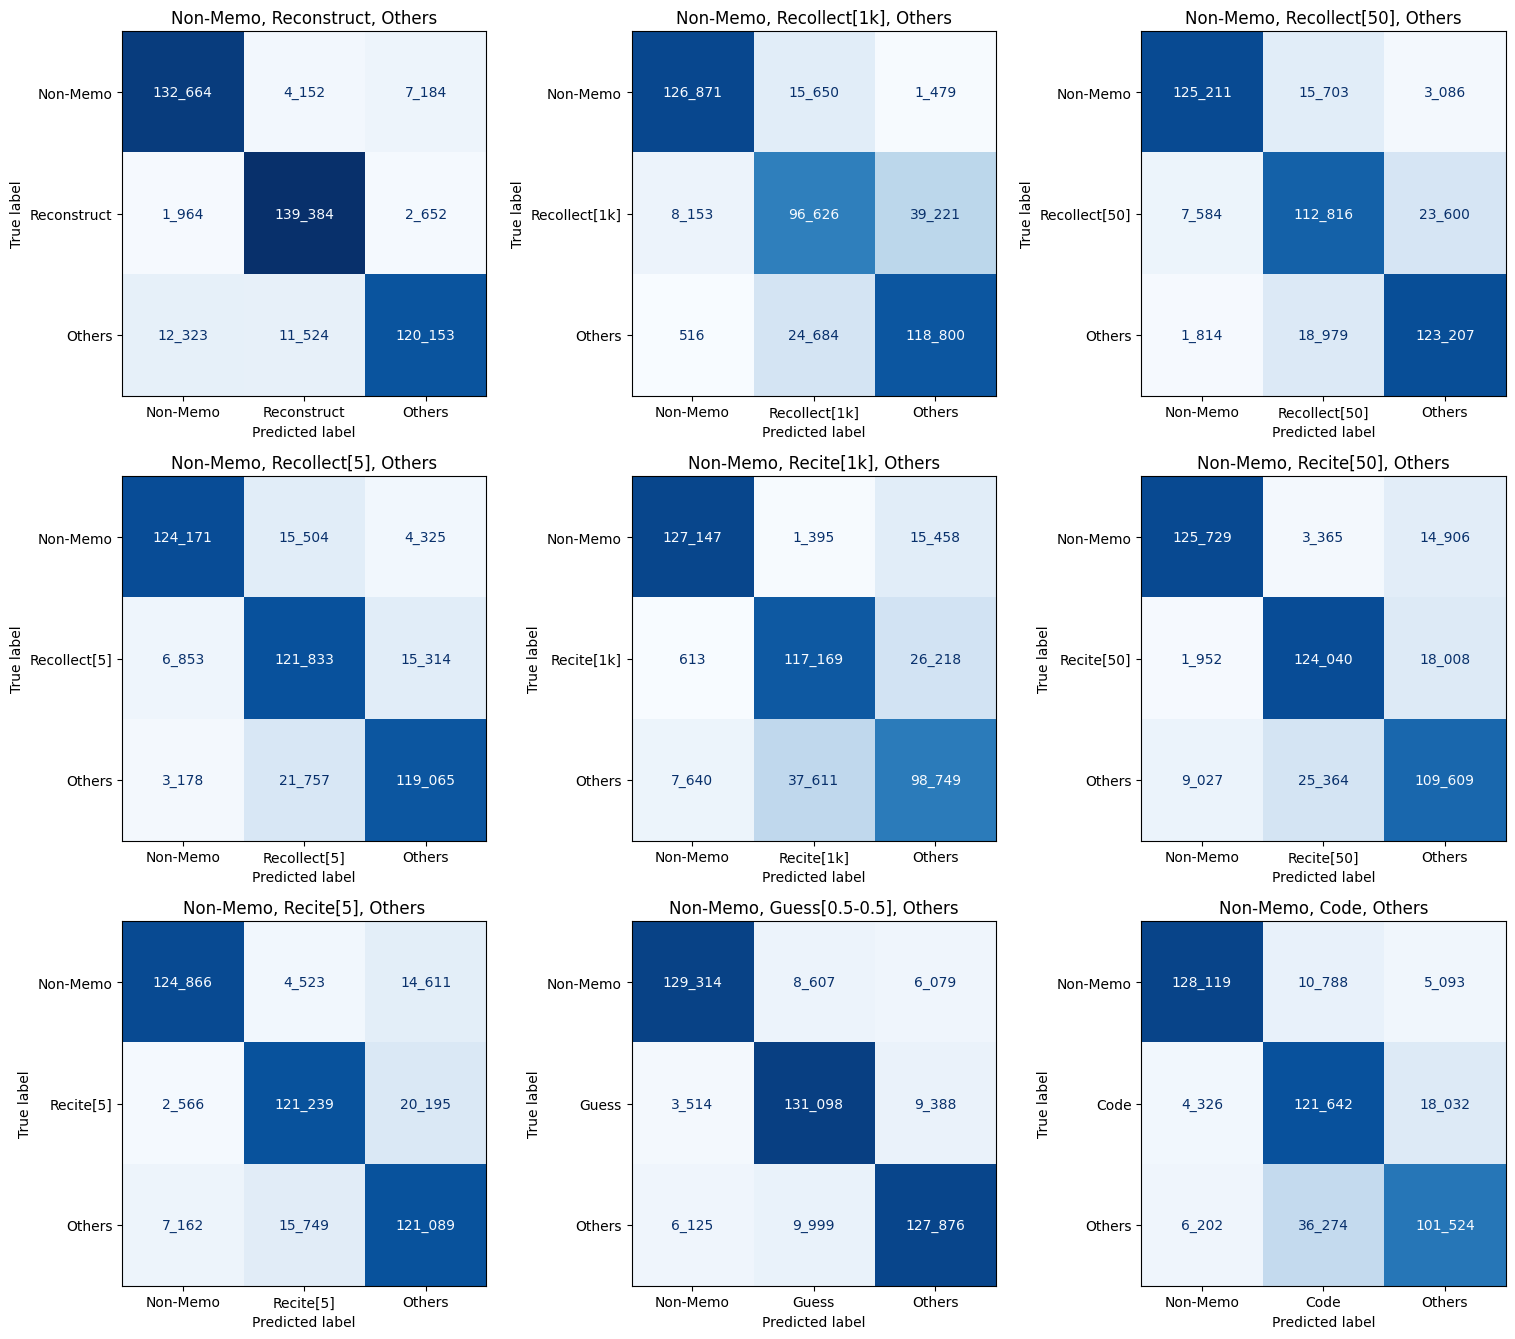

In [90]:
conf_matrix_to_plot = {
    (tax_name, dupl_thd) :v
    for (tax_name, dupl_thd), v in conf_matrix_per_tax_name_and_thd.items()
    if "merge" in tax_name
}

conf_matrix_to_plot = {
    k:v
    for (idx, (k,v)) in enumerate(conf_matrix_to_plot.items())
    if idx >= 18
}

num_tax_names = len(conf_matrix_to_plot)

n_cols = 3
n_rows = (num_tax_names - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4.5*n_rows))

global_min = min(np.min(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())
global_max = max(np.max(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())

used_ax_idx = []

for idx_tax_name, (tax_name, dupl_thd) in enumerate(sorted(conf_matrix_to_plot, reverse=True)):

    if idx_tax_name > 27:
        idx_tax_name += 1

    used_ax_idx.append(idx_tax_name)

    conf_matrix = conf_matrix_to_plot[tax_name, dupl_thd]
    idx_col = idx_tax_name % n_cols
    idx_row = idx_tax_name // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    display = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix,
        display_labels=get_titles(tax_name, dupl_thd),
    )
    display.plot(
        cmap=plt.cm.Blues,
        values_format="_d",
        ax=ax,
        colorbar=False,
    )
    display.im_.set_clim(global_min, global_max)
    titles = get_titles(tax_name, dupl_thd, remove_linebreak=True)
    titles_processed = [elt.replace("Guess", "Guess[0.5-0.5]") for elt in titles]
    display.ax_.set_title(", ".join(titles_processed))

    # Update tax checking
    tax_plotted_count[tax_name, dupl_thd] += 1

for idx_to_off in range(n_cols * n_rows):
    if idx_to_off in used_ax_idx:
        continue
    
    idx_col = idx_to_off % n_cols
    idx_row = idx_to_off // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    ax.set_axis_off()


fig.tight_layout()
fig.show()
if SIZE is None:
    fig.savefig(paths.figures / f"03_full_confusion_matrix_3_classes_part_3.pdf")

In [91]:
if len(tax_plotted_count) != 54:
    raise ValueError("Wrong taxonomy count check!!")

for k, v in tax_plotted_count.items():
    if v != 1:
        raise ValueError("Wrong taxonomy count check!!")

## Evaluation metric

In [68]:
min_f1 = {}
mean_f1 = {}
min_prec = {}
mean_prec = {}
min_rec = {}
mean_rec = {}

for idx_tax_name, (tax_name, dupl_thd) in enumerate(sorted(conf_matrix_per_tax_name_and_thd, reverse=True)):
    conf_matrix: np.ndarray = conf_matrix_per_tax_name_and_thd[tax_name, dupl_thd]
    
    # Precision
    num_sample = np.sum(conf_matrix, axis=0)
    precision = conf_matrix.diagonal() / num_sample

    # Recall
    num_sample = np.sum(conf_matrix, axis=1)
    recall = conf_matrix.diagonal() / num_sample
    
    # F1
    f1_score = 2 / (1/precision + 1/recall)

    # Flush
    min_f1[tax_name, dupl_thd] = np.min(f1_score)
    mean_f1[tax_name, dupl_thd] = np.mean(f1_score)
    min_prec[tax_name, dupl_thd] = np.min(precision)
    mean_prec[tax_name, dupl_thd] = np.mean(precision)
    min_rec[tax_name, dupl_thd] = np.min(recall)
    mean_rec[tax_name, dupl_thd] = np.mean(recall)

## Perf group by

In [69]:
# Group by "patterns_cfg"
df_grouped = df.groupby(["tax_name", "patterns_duplicates_threshold"]).agg({
    "tax_name": "first",  # Take the first value (same for all rows in a group)
    "patterns_duplicates_threshold": "first",
    "num_classes": "first",  # Same
    "patterns_size": "first",
    "eval_loss_1": "mean",
    "eval_loss_2": "mean",
    "eval_loss_3": "mean",
    "overall_accuracy_1": "mean",
    "overall_accuracy_2": "mean",
    "overall_accuracy_3": "mean",
}).reset_index(drop=True)

# Compute final mean values over steps 1, 2, 3
df_grouped["mean_eval_loss"] = df_grouped[["eval_loss_1", "eval_loss_2", "eval_loss_3"]].mean(axis=1)
df_grouped["mean_overall_accuracy"] = df_grouped[["overall_accuracy_1", "overall_accuracy_2", "overall_accuracy_3"]].mean(axis=1)

# Keep only the required columns and remove some lines
line_to_remove = (
    (
        df_grouped["tax_name"].str.contains("merge_2_other_reconstruct")
        | df_grouped["tax_name"].str.contains("merge_2_other_guess")
        | df_grouped["tax_name"].str.contains("merge_2_other_code")
    ) & (df_grouped["patterns_duplicates_threshold"] != DELTA_INVARIANT_TO_KEEP)
)
df_final = df_grouped[["tax_name", "num_classes", "mean_eval_loss", "patterns_duplicates_threshold"]].loc[~line_to_remove]

### Adding min accuracy

In [70]:
df_final = df_final.copy()
df_final["min_f1"] = [100*min_f1[tax_name, dupl_thd] for tax_name, dupl_thd in zip(df_final["tax_name"], df_final["patterns_duplicates_threshold"])]
df_final["mean_f1"] = [100*mean_f1[tax_name, dupl_thd] for tax_name, dupl_thd in zip(df_final["tax_name"], df_final["patterns_duplicates_threshold"])]
df_final["min_prec"] = [100*min_prec[tax_name, dupl_thd] for tax_name, dupl_thd in zip(df_final["tax_name"], df_final["patterns_duplicates_threshold"])]
df_final["mean_prec"] = [100*mean_prec[tax_name, dupl_thd] for tax_name, dupl_thd in zip(df_final["tax_name"], df_final["patterns_duplicates_threshold"])]
df_final["min_rec"] = [100*min_rec[tax_name, dupl_thd] for tax_name, dupl_thd in zip(df_final["tax_name"], df_final["patterns_duplicates_threshold"])]
df_final["mean_rec"] = [100*mean_rec[tax_name, dupl_thd] for tax_name, dupl_thd in zip(df_final["tax_name"], df_final["patterns_duplicates_threshold"])]

### Version with pretty names

In [71]:
df_final_pretty_names = df_final[["tax_name", "num_classes", "min_f1", "mean_f1", "min_prec", "mean_prec", "min_rec", "mean_rec", "mean_eval_loss"]].copy()
df_final_pretty_names["tax_name"] = [", ".join(get_titles(tax_name, dupl_thd, remove_linebreak=True)) for tax_name, dupl_thd in zip(df_final["tax_name"], df_final["patterns_duplicates_threshold"])]
df_final_pretty_names = df_final_pretty_names.sort_values(by=["num_classes", "min_f1"], ascending=[False, False])
dumpable = df_final_pretty_names.round(decimals=1)
dumpable["mean_eval_loss"] = df_final_pretty_names["mean_eval_loss"].round(decimals=4)
dumpable.to_csv(paths.figures / f"03_large_table_{SIZE if SIZE is not None else ''}.csv", index=False)
df_final_pretty_names

,tax_name,num_classes,min_f1,mean_f1,min_prec,mean_prec,min_rec,mean_rec,mean_eval_loss
49,"Non-Memo, Recollect[50], Code, Others",4,72.769260,77.942845,71.307356,78.238951,72.688194,77.812674,0.044979
48,"Non-Memo, Recollect[5], Code, Others",4,71.981324,78.429977,70.498393,79.052461,71.196528,78.341840,0.044231
51,"Non-Memo, Recollect[5], Guess, Others",4,71.475134,79.817853,65.655303,80.593862,68.357639,79.656771,0.040238
42,"Non-Memo, Recite[5], Guess, Others",4,70.335445,79.179422,63.257269,80.586469,69.952778,78.857986,0.043509
52,"Non-Memo, Recollect[50], Guess, Others",4,69.193147,79.769743,66.882254,80.027515,71.669444,79.649826,0.040200
36,"Non-Memo, Guess, Recite[5], Others",4,69.146461,79.471219,63.326018,80.414569,76.145139,79.073958,0.041640
54,"Non-Memo, Recollect[5], Reconstruct, Others",4,68.316601,80.564798,61.197722,81.872616,75.356250,80.071181,0.039264
55,"Non-Memo, Recollect[50], Reconstruct, Others",4,68.279185,81.617811,63.807920,82.260253,73.424306,81.284028,0.037303
43,"Non-Memo, Recite[50], Guess, Others",4,65.654747,77.818691,62.523086,78.399165,69.116667,77.631424,0.043662
57,"Non-Memo, Reconstruct, Recite[5], Others",4,65.201695,79.388643,60.936406,80.130974,70.109028,79.038021,0.041236


In [72]:
df_final_pretty_names[["tax_name", "num_classes", "min_f1"]].round(decimals=1).to_csv(paths.figures / f"03_small_table_{SIZE if SIZE is not None else ''}.csv", index=False)

### 4 categories

In [73]:
to_plot = df_final[df_final["num_classes"] == 4]
to_plot = to_plot.sort_values(by="min_f1", ascending=True)
to_plot

,tax_name,num_classes,mean_eval_loss,patterns_duplicates_threshold,min_f1,mean_f1,min_prec,mean_prec,min_rec,mean_rec
40,other_recite_code_recollect,4,0.051157,50,49.663162,69.872448,56.997130,70.557283,44.001389,70.187847
39,other_recite_code_recollect,4,0.050393,5,49.772127,69.985874,55.775646,70.872858,44.935417,70.062674
35,other_code_recite_recollect,4,0.051078,1000,55.433486,67.951436,59.966674,68.842391,49.843750,68.330556
59,other_reconstruct_recite_recollect,4,0.038580,1000,59.057528,78.159688,61.872561,78.073574,56.487500,78.502257
34,other_code_recite_recollect,4,0.051152,50,59.096271,69.341318,53.434532,70.417326,59.116667,68.892535
47,other_recite_reconstruct_recollect,4,0.039204,1000,59.714254,78.040628,63.013804,77.909509,56.743056,78.548438
50,other_recollect_code_recite,4,0.048363,1000,59.729579,72.266121,63.554535,72.563875,56.338889,72.272396
53,other_recollect_guess_recite,4,0.040216,1000,61.123698,77.487256,63.825944,77.638755,58.640972,77.557812
38,other_guess_recite_recollect,4,0.040366,1000,61.545172,77.000534,62.364365,77.034916,60.747222,77.097917
46,other_recite_reconstruct_recollect,4,0.041211,50,61.758953,78.960236,62.582347,79.229740,60.956944,79.077951


/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/186492595.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


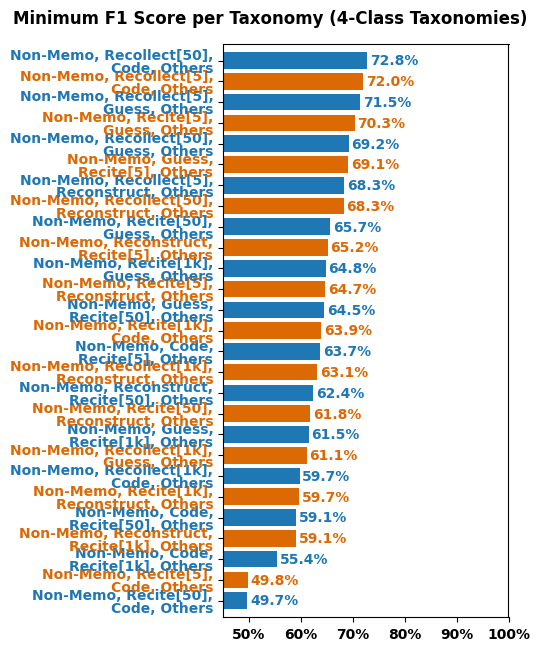

In [74]:
fig, ax = plt.subplots(figsize=(5.5, 6.6))

# Prepapring values
labels_as_list_to_plot = [
    get_titles(tax_name, dupl_thd, remove_linebreak=False)
    for tax_name, dupl_thd in zip(to_plot["tax_name"], to_plot["patterns_duplicates_threshold"])
]
labels_to_plot = [
    f'{elt[0]}, {elt[1]},\n{elt[2]}, {elt[3]}'
    for elt in labels_as_list_to_plot
]
x_range_to_plot = [k for k in range(len(labels_to_plot))]
values_to_plot = to_plot["min_f1"]
colors_to_plot = (len(values_to_plot) * ["#1f77b4", "#db6904"])[:len(values_to_plot)]

# Create bar plot
bars = ax.barh(x_range_to_plot, values_to_plot, color=colors_to_plot)

# Add value labels on top of each bar
for idx_bar, bar in enumerate(bars):
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + 0.4,
        f"{bar.get_width()/100:.1%}", 
        ha="left", va="center", fontsize=10,
        fontweight="bold",
        color=colors_to_plot[idx_bar]
    )

# Rotate x-axis labels for better visibility
ax.set_yticks(
    x_range_to_plot,
    labels_to_plot,
    ha="right",
    linespacing=0.9,
    fontsize=10,
    fontweight="bold",
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Tick color
for tick_label, color in zip(ax.get_yticklabels(), colors_to_plot):
    tick_label.set_color(color)

for tick_label in ax.get_xticklabels():
    tick_label.set_fontweight("bold")

# # Labels and title
ax.set_ylim(min(x_range_to_plot) - 0.8, max(x_range_to_plot) + 0.8)
ax.set_xlim(45, 100)
fig.suptitle("Minimum F1 Score per Taxonomy (4-Class Taxonomies)", size=12, fontweight="bold")

# # Show the plot
fig.tight_layout()
fig.show()
# fig.savefig(paths.figures / f"03_tax_perf_4_classes.pdf")

### 3 categories

In [75]:
to_plot = df_final[df_final["num_classes"] == 3]
to_plot = to_plot.sort_values(by="min_f1", ascending=True)
to_plot

,tax_name,num_classes,mean_eval_loss,patterns_duplicates_threshold,min_f1,mean_f1,min_prec,mean_prec,min_rec,mean_rec
2,merge_1_other_code_recollect_recite,3,0.035975,1000,66.108821,76.802851,65.566279,77.002528,66.660417,76.643981
14,merge_1_other_recite_reconstruct_recollect,3,0.036430,1000,66.685392,75.882845,62.311679,76.506246,66.122222,75.688889
17,merge_1_other_reconstruct_recollect_recite,3,0.033855,1000,68.029125,78.939870,70.992217,79.041318,65.303472,79.034722
11,merge_1_other_recite_guess_recollect,3,0.036650,1000,68.169812,76.264568,65.664272,76.766516,62.820139,76.333565
10,merge_1_other_recite_guess_recollect,3,0.039406,50,68.602154,75.613022,61.438005,77.155743,64.556250,75.234954
29,merge_2_other_recollect_recite_reconstruct,3,0.034008,1000,68.782745,79.280223,70.550526,79.545795,67.101389,79.235417
7,merge_1_other_recite_code_recollect,3,0.038653,50,69.416115,75.823307,61.126851,77.868046,62.028472,75.524074
26,merge_2_other_recite_reconstruct_recollect,3,0.033911,1000,69.437637,79.506360,70.321524,79.750141,68.575694,79.413194
5,merge_1_other_guess_recollect_recite,3,0.032523,1000,69.880235,80.548648,74.706183,80.894949,65.236111,80.730556
9,merge_1_other_recite_guess_recollect,3,0.037747,5,71.199792,77.566694,63.610633,79.211580,68.581250,77.188657


/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/3453530244.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


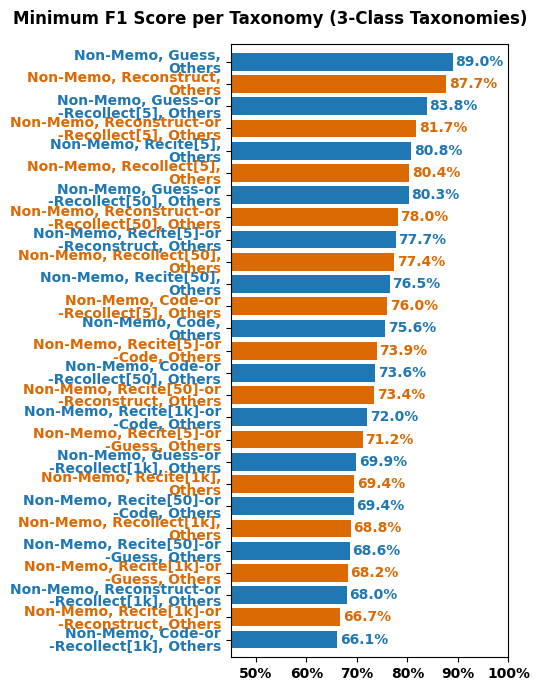

In [76]:
fig, ax = plt.subplots(figsize=(5.5, 7))

# Prepapring values
labels_as_list_to_plot = [
    get_titles(tax_name, dupl_thd, remove_linebreak=False)
    for tax_name, dupl_thd in zip(to_plot["tax_name"], to_plot["patterns_duplicates_threshold"])
]
labels_to_plot = [
    f'{elt[0]}, {elt[1]}, {elt[2]}' if ("\n" in elt[1] or "\n" in elt[2]) else f'{elt[0]}, {elt[1]},\n{elt[2]}'
    for elt in labels_as_list_to_plot
]
x_range_to_plot = [k for k in range(len(labels_to_plot))]
values_to_plot = to_plot["min_f1"]
colors_to_plot = (len(values_to_plot) * ["#1f77b4", "#db6904"])[:len(values_to_plot)]

# Create bar plot
bars = ax.barh(x_range_to_plot, values_to_plot, color=colors_to_plot)

# Add value labels on top of each bar
for idx_bar, bar in enumerate(bars):
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + 0.4,
        f"{bar.get_width()/100:.1%}", 
        ha="left", va="center", fontsize=10,
        fontweight="bold",
        color=colors_to_plot[idx_bar]
    )

# Rotate x-axis labels for better visibility
ax.set_yticks(
    x_range_to_plot,
    labels_to_plot,
    ha="right",
    linespacing=0.9,
    fontsize=10,
    fontweight="bold",
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Tick color
for tick_label, color in zip(ax.get_yticklabels(), colors_to_plot):
    tick_label.set_color(color)

for tick_label in ax.get_xticklabels():
    tick_label.set_fontweight("bold")

# # Labels and title
ax.set_ylim(min(x_range_to_plot) - 0.8, max(x_range_to_plot) + 0.8)
ax.set_xlim(45, 100)
fig.suptitle("Minimum F1 Score per Taxonomy (3-Class Taxonomies)", size=12, fontweight="bold")

# # Show the plot
fig.tight_layout()
fig.show()
# fig.savefig(paths.figures / "03_tax_perf_3_classes.pdf")

## Specific confusion matrices

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_14026/2728908194.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


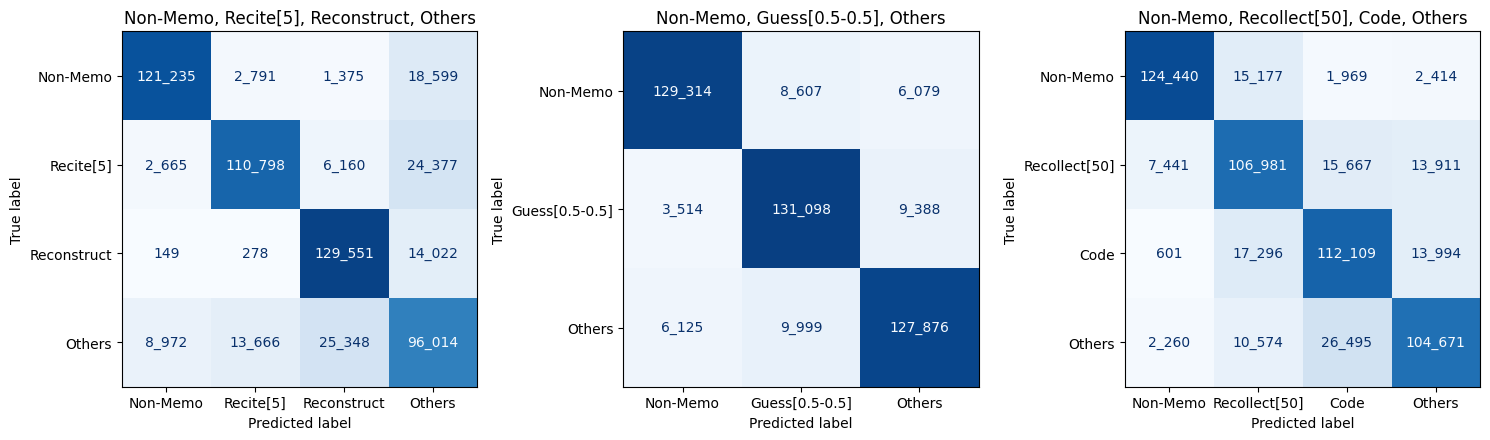

In [77]:
if SIZE is None:

    keys_to_plot = [
        ("other_recite_reconstruct_recollect", 5),
        ("merge_2_other_guess_recollect_recite", DELTA_INVARIANT_TO_KEEP),
        ("other_recollect_code_recite", 50),
    ]

    num_tax_names = len(keys_to_plot)

    n_cols = 3
    n_rows = (num_tax_names - 1) // n_cols + 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4.5*n_rows))

    global_min = min(np.min(conf_matrix) for _, conf_matrix in conf_matrix_per_tax_name_and_thd.items())
    global_max = max(np.max(conf_matrix) for _, conf_matrix in conf_matrix_per_tax_name_and_thd.items())

    displays = []

    for idx_tax_name, (tax_name, dupl_thd) in enumerate(keys_to_plot):
        conf_matrix = conf_matrix_per_tax_name_and_thd[tax_name, dupl_thd]
        idx_col = idx_tax_name % n_cols
        idx_row = idx_tax_name // n_cols 
        ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

        titles = get_titles(tax_name, dupl_thd, remove_linebreak=True)
        titles_processed = [elt if "Guess" not in elt else "Guess[0.5-0.5]" for elt in titles]

        display = ConfusionMatrixDisplay(
            confusion_matrix=conf_matrix,
            display_labels=titles_processed,
        )
        display.plot(
            cmap=plt.cm.Blues,
            values_format="_d",
            ax=ax,
            colorbar=False,
        )
        display.im_.set_clim(global_min, global_max)
        display.ax_.set_title(", ".join(titles_processed))

        # Save display
        displays.append(display)

    for idx_to_off in range(len(conf_matrix_per_tax_name_and_thd), n_cols * n_rows):
        idx_col = idx_to_off % n_cols
        idx_row = idx_to_off // n_cols 
        ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

        ax.set_axis_off()

    fig.tight_layout()
    fig.show()
    fig.savefig(paths.figures / f"03_example_confusion_matrix.pdf")